In [1]:
ROLLNUMBER = 4228

NUM_CLASSES = 6
labels_dict = {"freeway":0,"mountain":1,"palace":2,"river":3,"ship":4,"stadium":5}

# Batch size is a hyperparameter, feel free to change this. You may also change the number of epochs.
BATCH_SIZE = 32
EPOCHS = 5

In [2]:
from tensorflow import keras
from tensorflow.keras import layers, Model
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from keras.applications import VGG16
from keras.layers import Flatten, Dense, Dropout, LeakyReLU, Input, concatenate, add, Reshape, Conv2D, Activation
from keras.optimizers import Adam, RMSprop, Adagrad, SGD
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical, plot_model
from glob import glob
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import collections
import os
from scipy.spatial.distance import cosine
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImageDataGenerator
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
from keras.applications.vgg16 import VGG16

In [3]:
BATCH = 64
train_gen = ImageDataGenerator(validation_split = 0.2)
# train data and val data
train_data = train_gen.flow_from_directory('SatView/Images/', target_size = (224, 224), subset = "training", batch_size = BATCH)
validate_data = train_gen.flow_from_directory('SatView/Images/', target_size = (224, 224),subset = "validation", batch_size = BATCH)

Found 3360 images belonging to 6 classes.
Found 840 images belonging to 6 classes.


In [4]:
inputs = layers.Input(shape=(224, 224, 3))
base_model_sat = VGG16(include_top = False, weights='imagenet', input_tensor=inputs)
base_model_str = VGG16(include_top = False, weights='imagenet', input_tensor=inputs)
base_model_str.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

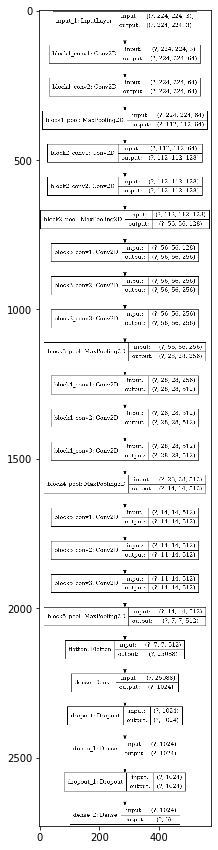

In [5]:
# Add layers to your Satellite Base Model
base_model_sat.trainable = False
x = base_model_sat.output
x = layers.Flatten()(x)
x = layers.Dense(1024, activation = "relu")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1024, activation = "relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation = "softmax")(x)
sat_classification_model = Model(inputs=inputs, outputs=outputs)
# get model summary
sat_classification_model.summary()
plot_model(sat_classification_model, to_file='model_plot.png', show_shapes=True)
plt.figure(figsize = (15,15))
plt.imshow(cv2.imread('model_plot.png'))
plt.show()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

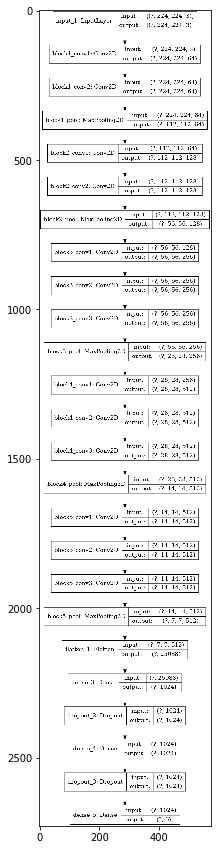

In [6]:
# Add layers to your Street Base Model
base_model_str.trainable = False
x = x = base_model_str.output
x = layers.Flatten()(x)
x = layers.Dense(1024, activation = "relu")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1024, activation = "relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation = "softmax")(x)
str_classification_model = Model(inputs=inputs, outputs=outputs)
# get model summary
str_classification_model.summary()
plot_model(str_classification_model, to_file='model_plot.png', show_shapes=True)
plt.figure(figsize = (15,15))
plt.imshow(cv2.imread('model_plot.png'))
plt.show()

In [7]:
# Freeze layers for BOTH models
for L in base_model_sat.layers:
    L.trainable = False

for L in base_model_str.layers:
    L.trainable = False

In [8]:
# Compile
sat_classification_model.compile(optimizer = SGD(lr=0.0001), 
                loss ='categorical_crossentropy',
                metrics = ['accuracy'])
str_classification_model.compile(optimizer = SGD(lr=0.0001), 
                loss ='categorical_crossentropy',
                metrics = ['accuracy'])

In [9]:
# Callbacks for Satellite Model
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor ='val_acc', patience = 2, verbose = 1, factor = 0.5, min_lr = 0.001)
checkpoint = ModelCheckpoint("Results_satellite.h5", monitor = 'val_acc', verbose=1, save_best_only = True, save_weights_only = False, mode = 'auto', period = 1)
callback_sat = [checkpoint, earlystop, learning_rate_reduction]
if not os.path.exists('Models'):
    os.mkdir('Models/')

In [10]:
# Callbacks for Street Model
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor ='val_acc', patience = 2, verbose = 1, factor = 0.5, min_lr = 0.001)
checkpoint = ModelCheckpoint("Results_street.h5", monitor = 'val_acc', verbose=1, save_best_only = True, save_weights_only = False, mode = 'auto', period = 1)
callback_str = [checkpoint, earlystop,learning_rate_reduction]
if not os.path.exists('Models'):
    os.mkdir('Models/')


In [11]:
sat_classification_model.load_weights("sat_weights")
str_classification_model.load_weights("str_weights")

sat_classification_model.compile(optimizer = SGD(lr=0.0001), 
                loss ='categorical_crossentropy',
                metrics = ['accuracy'])
str_classification_model.compile(optimizer = SGD(lr=0.0001), 
                loss ='categorical_crossentropy',
                metrics = ['accuracy'])

In [19]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [13]:
sat_hist = sat_classification_model.fit_generator(train_data, steps_per_epoch = train_data.samples // BATCH, validation_data = validate_data, 
                        validation_steps = validate_data.samples // BATCH, epochs = 1, callbacks = callback_sat)

Instructions for updating:
Please use Model.fit, which supports generators.
52/52 [==============================] - 525s 10s/step - loss: 1.2514 - accuracy: 0.8617 - val_loss: 0.1329 - val_accuracy: 0.9700 - lr: 1.0000e-04


In [14]:
str_hist = str_classification_model.fit_generator(train_data, steps_per_epoch = train_data.samples // BATCH, validation_data = validate_data, 
                        validation_steps = validate_data.samples // BATCH, epochs = 1, callbacks = callback_str)

52/52 [==============================] - 531s 10s/step - loss: 7.4640 - accuracy: 0.4199 - val_loss: 2.1754 - val_accuracy: 0.6526 - lr: 1.0000e-04


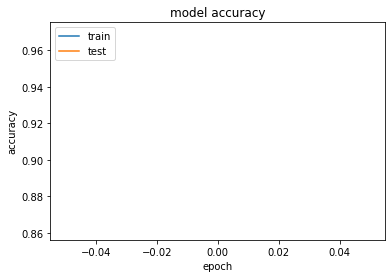

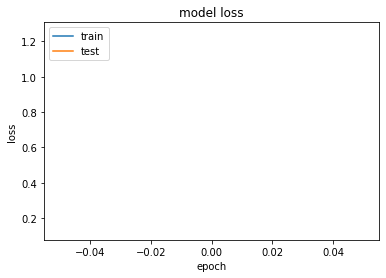

In [20]:
plot_accuracy(sat_hist)
plot_loss(sat_hist)

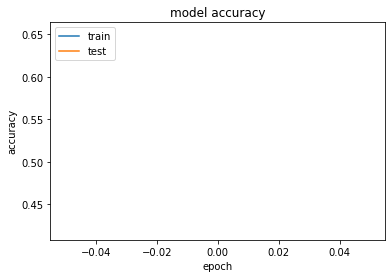

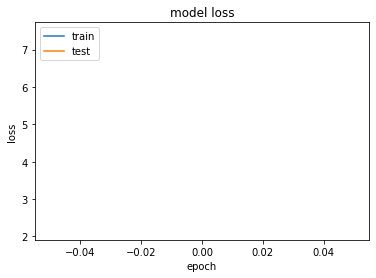

In [16]:
plot_accuracy(str_hist)
plot_loss(str_hist)